In [1]:
!pip install comet_ml

In [0]:
from comet_ml import Experiment

In [0]:
MODEL_NAME = "Pytorch_Cramer_All_1layer"

import os
#os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [4]:
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
import scipy
from tqdm import tqdm_notebook, tqdm
from torch.autograd import Variable, grad
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/rich_utils')

In [0]:
import torch_utils_rich_mrartemev as utils_rich

## Data

In [0]:
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer

def prep_mc(train, test):
    data_train = pd.read_csv(train)
    data_val = pd.read_csv(test)
    scaler = QuantileTransformer(output_distribution="normal",
                                    n_quantiles=100000,
                                    subsample=int(1e10)).fit(data_train.drop(['Signal'], axis=1).values)
    data_train = pd.concat([utils_rich.scale_pandas(data_train.drop(['Signal'], axis=1), scaler), data_train.Signal], axis=1)
    data_val = pd.concat([utils_rich.scale_pandas(data_val.drop(['Signal'], axis=1), scaler), data_val.Signal], axis=1)
    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), ['Signal'])
    ])

    x = column_transformer.fit_transform(data_train)
    val = column_transformer.fit_transform(data_val)

    ohe_part_train = pd.get_dummies(data_train.Signal)
    ohe_part_val = pd.get_dummies(data_val.Signal)

    data_train = pd.concat([ohe_part_train, data_train.drop(['Signal'], axis=1)], axis=1)
    data_val = pd.concat([ohe_part_val, data_val.drop(['Signal'], axis=1)], axis=1)
    n_particles = len(ohe_part_train.columns)
    return data_train, data_val, n_particles, scaler

In [0]:
data_train, data_val, n_particles, scaler = prep_mc('/content/drive/My Drive/data/MCRICHdata/MCRICH_train.csv',
                                            '/content/drive/My Drive/data/MCRICHdata/MCRICH_test.csv')

In [10]:
data_train.head()

,Electron,Ghost,Kaon,Muon,Pion,Proton,TrackP,TrackPt,NumProtoParticles,RichDLLe,RichDLLmu,RichDLLk,RichDLLp,RichDLLbt
0,1,0,0,0,0,0,2.492753,1.607156,-1.198834,0.436221,0.324595,-0.266659,-0.605369,-0.904622
1,1,0,0,0,0,0,1.322625,0.609324,0.766339,0.457730,0.343613,-0.167275,0.162860,-0.472161
2,1,0,0,0,0,0,1.250824,0.299060,0.048560,0.672145,0.450283,-0.292292,0.515520,0.427368
3,1,0,0,0,0,0,-0.526969,-1.931739,-0.733843,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
4,1,0,0,0,0,0,1.328552,0.572059,0.271030,0.226480,0.395564,-1.034196,-0.867360,-0.774614


In [0]:
BATCH_SIZE = int(1e3)
LATENT_DIMENSIONS = 64

N_VAL = int(3e5)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
PARTICLES = list(data_train.columns[:n_particles])

In [0]:
from itertools import repeat

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

class ParticleSet(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, ind):
        return (self.data[ind, :-utils_rich.y_count],   #X
                self.data[ind, -utils_rich.y_count:],   #Dll
                np.argmax(self.data[ind, :n_particles]) #Signal
               )
    
def repeater(data_loader):
    for loader in repeat(data_loader):
        for data in loader:
            yield data
    
# https://github.com/pytorch/pytorch/issues/5398
# https://discuss.pytorch.org/t/implementing-an-infinite-loop-dataset-dataloader-combo/35567
train_loader = repeater(torch.utils.data.DataLoader(ParticleSet(data_train.values),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    pin_memory=True))

validation_set = {particle: repeater(torch.utils.data.DataLoader(ParticleSet(data_val[data_val[particle] == 1].values),
                                                  batch_size=N_VAL,
                                                  shuffle=False,
                                                  pin_memory=True)) for particle in PARTICLES}

In [0]:
for i in next(validation_set['Kaon']):
    print(i.shape)

torch.Size([300000, 9])
torch.Size([300000, 5])
torch.Size([300000])


## Model

In [0]:
CRAMER_DIM = 256
NUM_LAYERS = 5

def get_noise(batch_size, mean=0, std=1):
    return torch.zeros(batch_size, LATENT_DIMENSIONS).normal_(mean, std).to(device)

def get_labels(batch_size, n_classes=len(PARTICLES)):
    return torch.LongTensor(batch_size).random_(0, n_classes).to(device)

class Generator(nn.Module):
    def __init__(self, hidden_size=128, depth=5):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(len(PARTICLES), LATENT_DIMENSIONS)
        self.layers = nn.Sequential(
            nn.Linear(LATENT_DIMENSIONS + data_train.shape[1] - utils_rich.y_count, hidden_size),
            nn.LeakyReLU(0.05),
            *[nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.LeakyReLU(0.05)) for _ in range(depth)],
            nn.Linear(hidden_size, utils_rich.y_count),
        )

    def forward(self, x, labels=None, noise=None):
        noise = get_noise(x.shape[0])
        input_gen = torch.mul(self.label_emb(labels), noise)
        return self.layers(torch.cat([x, input_gen], dim=1))

    
class Critic(nn.Module):
    def __init__(self, hidden_size=128, depth=5):
        super(Critic, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(data_train.shape[1], hidden_size),
            nn.LeakyReLU(0.05),
            *[nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.LeakyReLU(0.05)) for _ in range(depth)],
        )
        self.out = nn.Sequential(nn.Linear(hidden_size, CRAMER_DIM))
        self.aux_layer = nn.Sequential(nn.Linear(hidden_size, len(PARTICLES)), nn.Softmax(dim=1))

    def forward(self, x):
        res = self.layers(x)
        out = self.out(res)
        label = self.aux_layer(res)
        return out, label

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [0]:
netG = Generator(depth=NUM_LAYERS).to(device)
netG.apply(init_weights)

netC = Critic(depth=NUM_LAYERS).to(device)
netC.apply(init_weights)

pass

In [20]:
device

'cuda'

In [0]:
optC = torch.optim.AdamW(netC.parameters())
lr_C = torch.optim.lr_scheduler.ExponentialLR(optimizer=optC, gamma=0.995)
optG = torch.optim.AdamW(netG.parameters())
lr_G = torch.optim.lr_scheduler.ExponentialLR(optimizer=optG, gamma=0.995)

In [0]:
labels_loss = torch.nn.CrossEntropyLoss()

## Train

In [0]:
LOGDIR = "/content/drive/My Drive/"
logdir = '/content/drive/My Drive/torch_model_exp4.pt'

CRITIC_ITERATIONS_CONST = 8
TOTAL_ITERATIONS = int(5e4)
VALIDATION_INTERVAL = 1000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


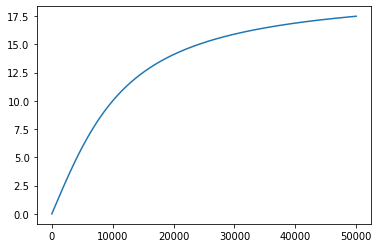

In [18]:
lambda_pt = lambda i: 20 / np.pi * 2 * torch.atan(torch.tensor(i, dtype=torch.float32, device=device)/1e4)

pt = []
for i in tqdm_notebook(range(50000)):
    pt.append(lambda_pt(i))
    
plt.plot(pt)

In [20]:
for i in next(train_loader):
    print(i.shape)

torch.Size([1000, 9])
torch.Size([1000, 5])
torch.Size([1000])


In [19]:
experiment = Experiment(api_key="k62CZajG08ctPlNYUYRv9YVdO",
                        project_name="rich", workspace="nzinci")


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/nzinci/rich/d120141cb1d04938bf6029fa23611d5f



In [0]:
def calc_gradient_penalty(real_data, fake_data, fake_data2):
    alpha = torch.rand(BATCH_SIZE, 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(device)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    
#     interpolates = torch.Tensor(interpolates, requires_grad=True)

    disc_interpolates = cramer_critic(interpolates, fake_data2)

    gradients = grad(outputs=disc_interpolates, inputs=interpolates,
                     grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                     create_graph=True, retain_graph=True, only_inputs=True)[0]
    # create_graph=True, retain_graph=True, only_inputs=True - crucial for our case

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [0]:
def cramer_critic(x, y):
    discriminated_x, _ = netC(x)
    discriminated_y, _ = netC(y)
    return torch.norm(discriminated_x - discriminated_y, dim=1) - torch.norm(discriminated_x, dim=1)

In [0]:
#LOAD MODEL
checkpoint = torch.load(logdir)
netC.load_state_dict(checkpoint[MODEL_NAME+'netC_state_dict'])
netG.load_state_dict(checkpoint[MODEL_NAME+'netG_state_dict'])
optC.load_state_dict(checkpoint[MODEL_NAME+'optC_state_dict'])
optG.load_state_dict(checkpoint[MODEL_NAME+'optG_state_dict'])
lr_C.load_state_dict(checkpoint[MODEL_NAME+'lr_C_state_dict'])
lr_G.load_state_dict(checkpoint[MODEL_NAME+'lr_G_state_dict'])

netC.eval()
netG.eval()

Generator(
  (layers): Sequential(
    (0): Linear(in_features=73, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.05)
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.05)
    )
    (4): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.05)
    )
    (5): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.05)
    )
    (6): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.05)
    )
    (7): Linear(in_features=128, out_features=5, bias=True)
  )
)

particle: Electron, epoch: 600


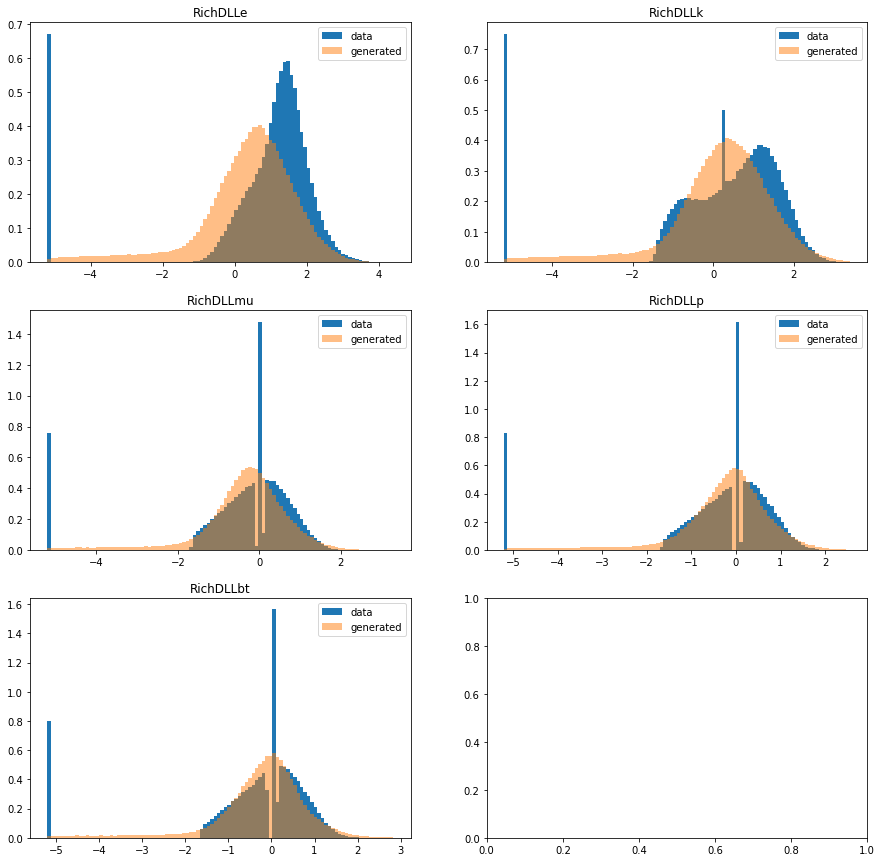

particle: Ghost, epoch: 600


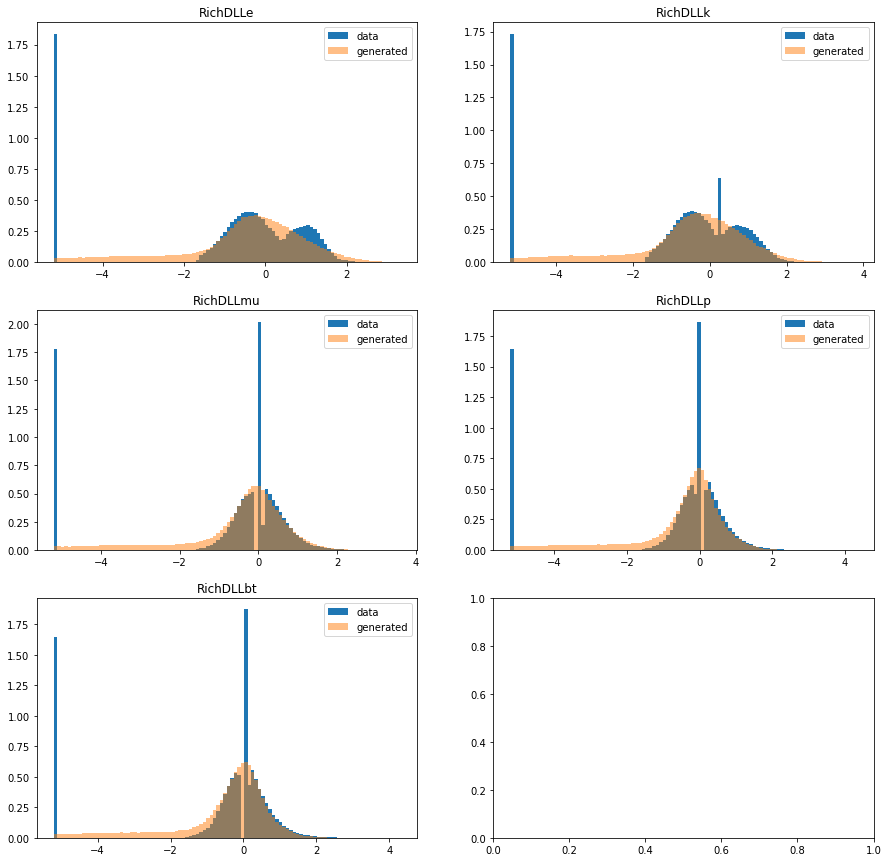

particle: Kaon, epoch: 600


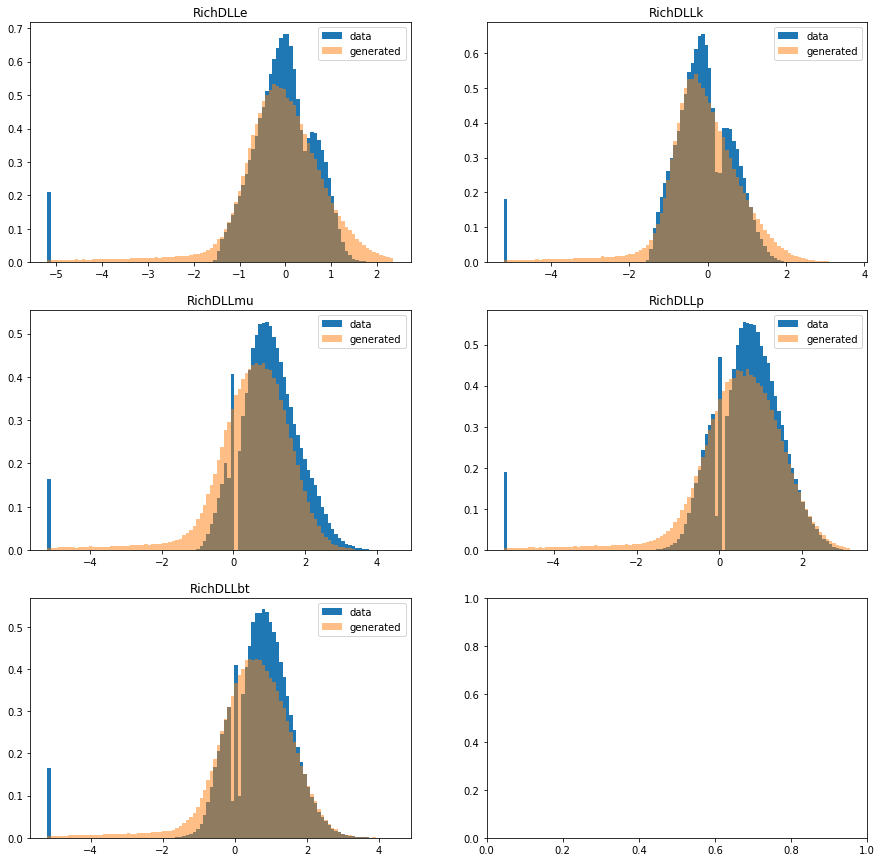

particle: Muon, epoch: 600


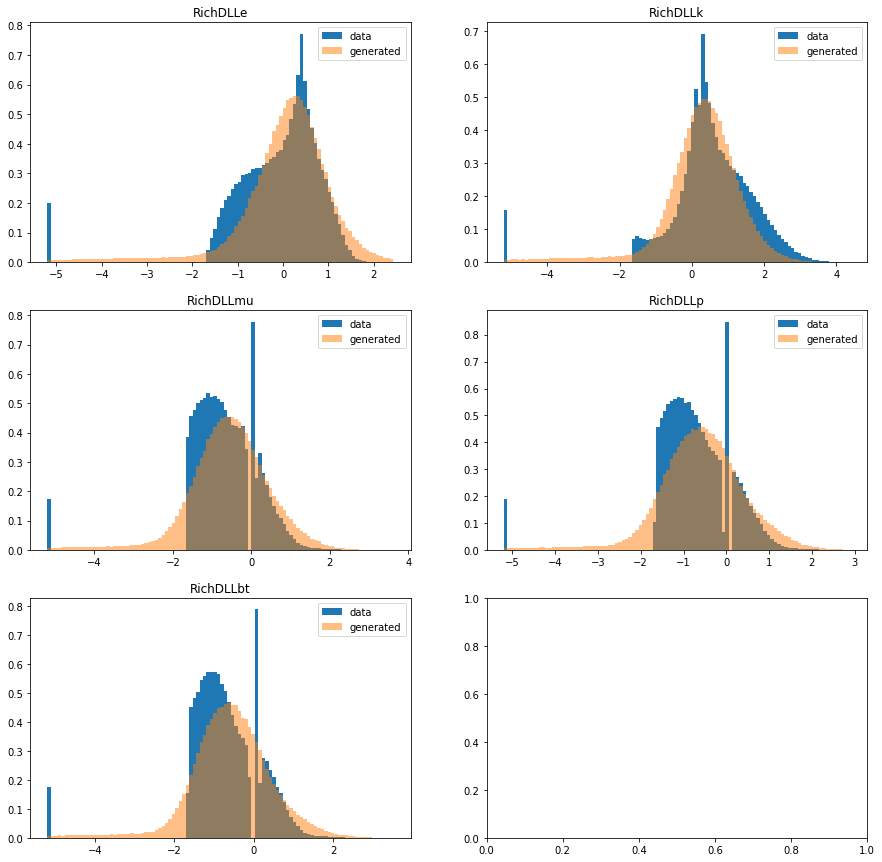

particle: Pion, epoch: 600


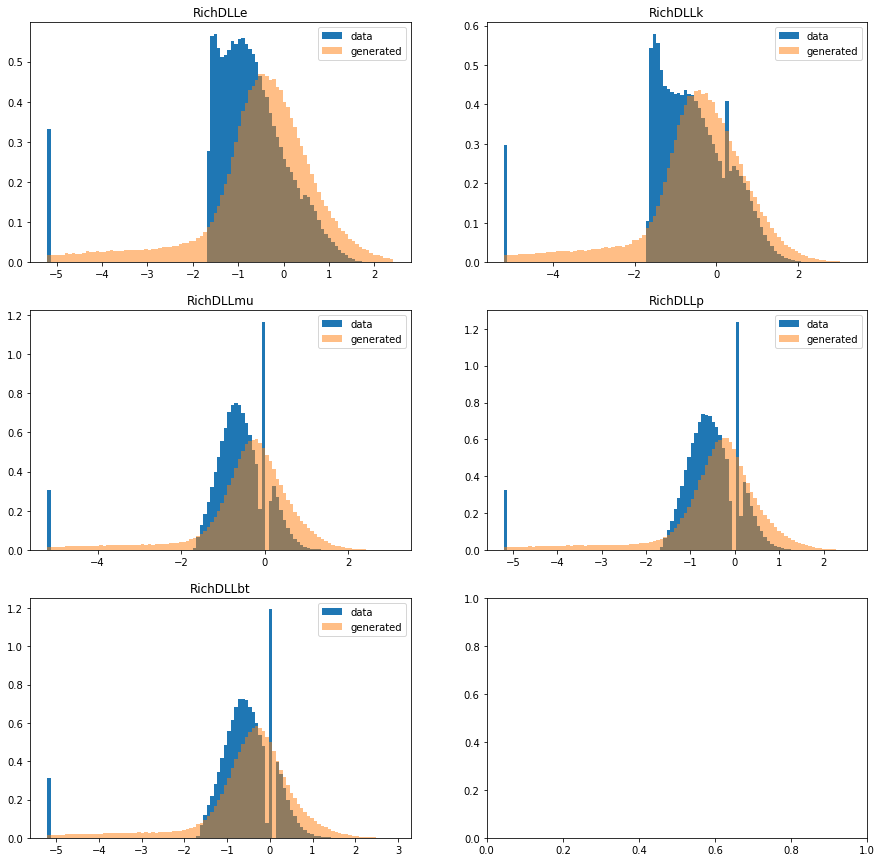

particle: Proton, epoch: 600


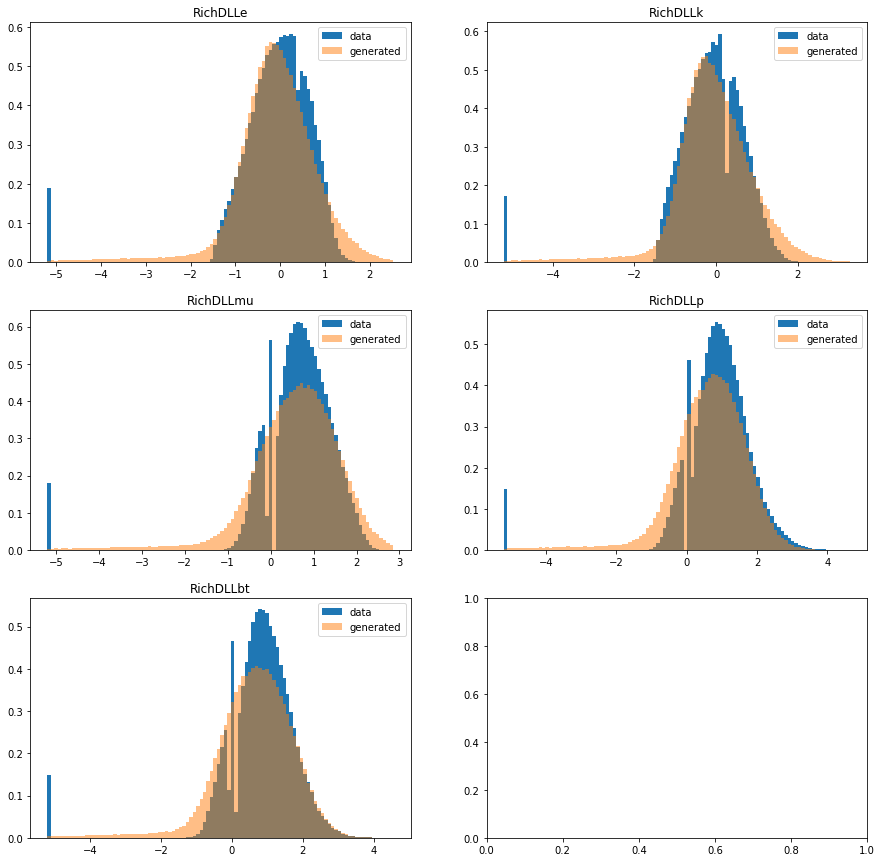

  0%|          | 666/500000 [12:14<59:38:50,  2.33it/s]

RuntimeError: ignored

In [24]:
for iteration in tqdm(range(10*TOTAL_ITERATIONS), position=0, leave=True):
    for critic_iter in range(CRITIC_ITERATIONS_CONST):
        x, dlls, signals = [i.to(device).type(dtype) for i in next(train_loader)]

        optC.zero_grad()
        
        netG.eval()
        netC.train()
        
        labels = get_labels(x.shape[0], n_classes=len(PARTICLES))
        real_full_0 = torch.cat([dlls, x], dim=1)    
        generated_1 = torch.cat([netG(x, labels=labels), x], dim=1)
        generated_2 = torch.cat([netG(x, labels=labels), x], dim=1)
        _, labels_real_0 = netC(real_full_0)
        _, labels_gen_1 = netC(generated_1)
        _, labels_gen_2 = netC(generated_2)
        
        generator_loss = torch.mean(cramer_critic(real_full_0, generated_2) - 
                                    cramer_critic(generated_1, generated_2))
        
        # GP
        gradient_penalty = calc_gradient_penalty(real_full_0, generated_1, generated_2)
        
        fake_loss = (labels_loss(labels_gen_1, labels) + labels_loss(labels_gen_2, labels)) / 2
        multiclass_loss = (labels_loss(labels_real_0, signals.long()) + fake_loss) / 2
        critic_loss = (lambda_pt(iteration) * gradient_penalty - generator_loss + multiclass_loss) / 2
        critic_loss.backward()
        optC.step()
        
    x, dlls, signals = [i.to(device).type(dtype) for i in next(train_loader)]
    
    netC.eval()
    netG.train()
    
    optG.zero_grad()

    labels = get_labels(x.shape[0], n_classes=len(PARTICLES))
    real_full_0 = torch.cat([dlls, x], dim=1)
    generated_1 = torch.cat([netG(x, labels=labels), x], dim=1)
    generated_2 = torch.cat([netG(x, labels=labels), x], dim=1)
    _, labels_gen_1 = netC(generated_1)
    _, labels_gen_2 = netC(generated_2)

    fake_loss = (labels_loss(labels_gen_1, labels) + labels_loss(labels_gen_2, labels)) / 2
    generator_loss = (torch.mean(cramer_critic(real_full_0, generated_2) -
                cramer_critic(generated_1, generated_2)) + fake_loss) / 2
    
    generator_loss.backward()
    optG.step()
    
    experiment.log_metrics({'Generator loss': generator_loss.item(),
                            'Critic loss': critic_loss.item()},
                            step=iteration)
    lr_C.step()
    lr_G.step()
    
    if iteration % 100 == 0:
        clear_output(False)
        for ind, particle in enumerate(PARTICLES):
            print('particle: {}, epoch: {}'.format(particle, iteration))
            with torch.no_grad():
                x, dlls, signal = [i.to(device).type(dtype) for i in next(validation_set[particle])]
                real_full = torch.cat([dlls, x], dim=1)

                labels = get_labels(x.shape[0], n_classes=len(PARTICLES))
                generated = netG(x, labels=labels)
                fig, axes = plt.subplots(3, 2, figsize=(15, 15))
                for INDEX, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
                    _, bins, _ = ax.hist(dlls[:, INDEX].cpu(),
                                        bins=100,
                                        label="data",
                                        density=True)
                    ax.hist(generated[:, INDEX].cpu(),
                            bins=bins,
                            label="generated",
                            alpha=0.5,
                            density=True)
                    ax.legend()
                    ax.set_title(utils_rich.dll_columns[INDEX])
                experiment.log_figure()
                plt.show()
experiment.end()

In [25]:
logdir = '/content/drive/My Drive/torch_model_exp4.pt'
torch.save({MODEL_NAME+'netC_state_dict': netC.state_dict(),
            MODEL_NAME+'netG_state_dict': netG.state_dict(),
            MODEL_NAME+'optC_state_dict': optC.state_dict(),
            MODEL_NAME+'optG_state_dict': optG.state_dict(),
            MODEL_NAME+'lr_C_state_dict': lr_C.state_dict(),
            MODEL_NAME+'lr_G_state_dict': lr_G.state_dict()
           }, logdir)
from sklearn.externals import joblib
os.makedirs('./preprocessors', exist_ok=True)
#joblib.dump(scaler, os.path.join('preprocessors', MODEL_NAME) + "_preprocessor.pkl")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Met

particle: Electron


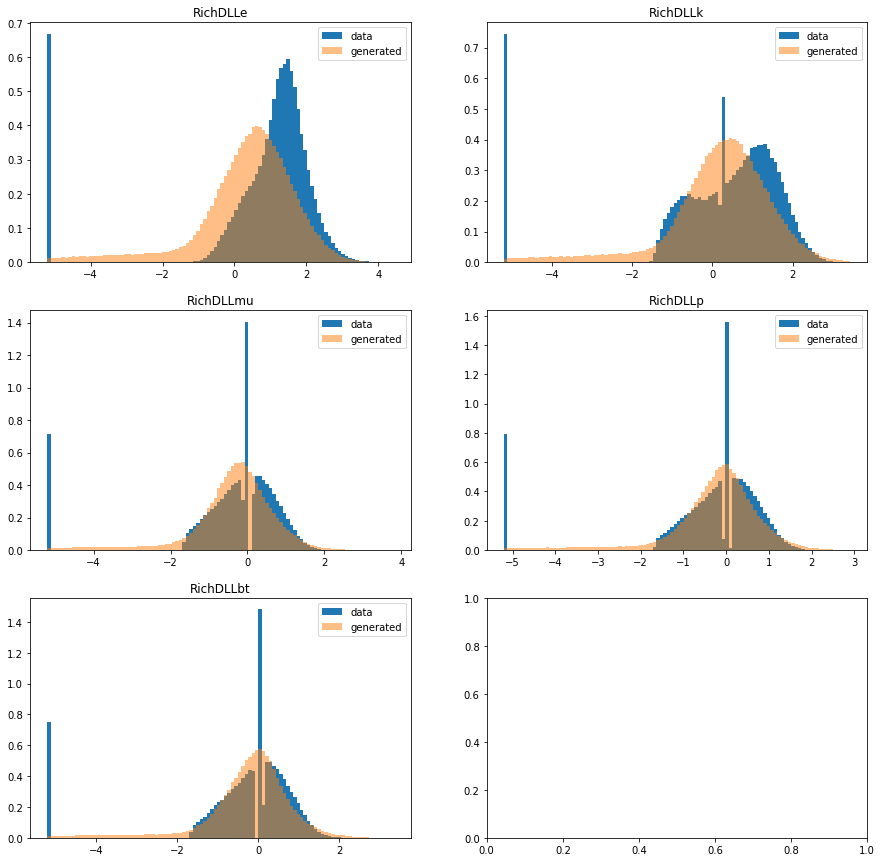

particle: Ghost


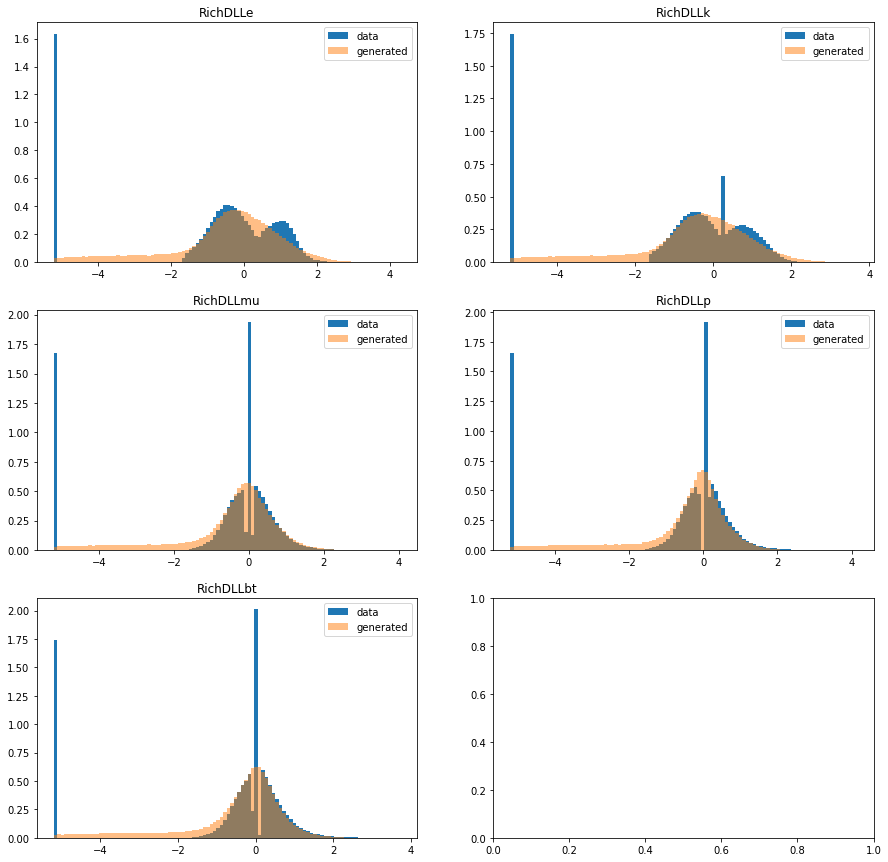

particle: Kaon


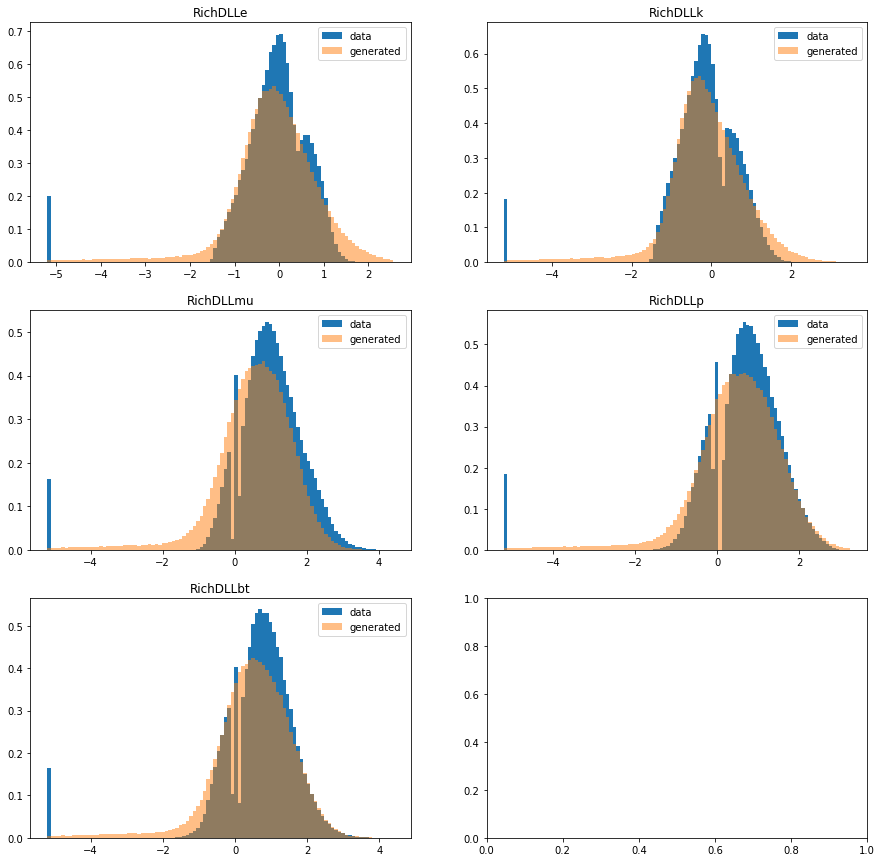

particle: Muon


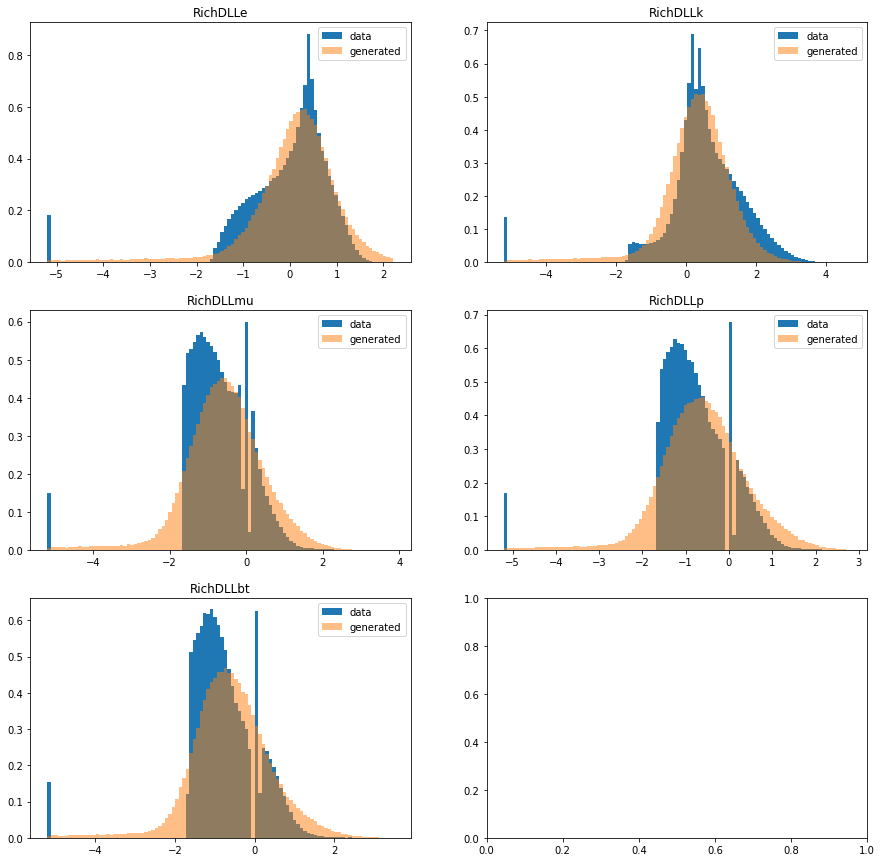

particle: Pion


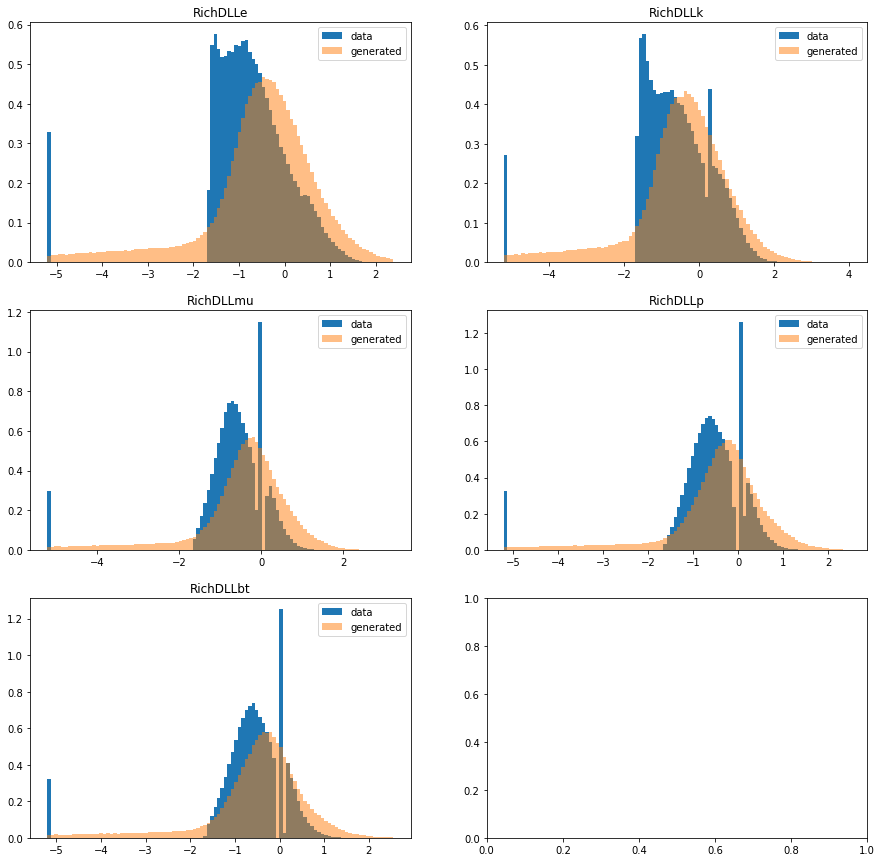

particle: Proton


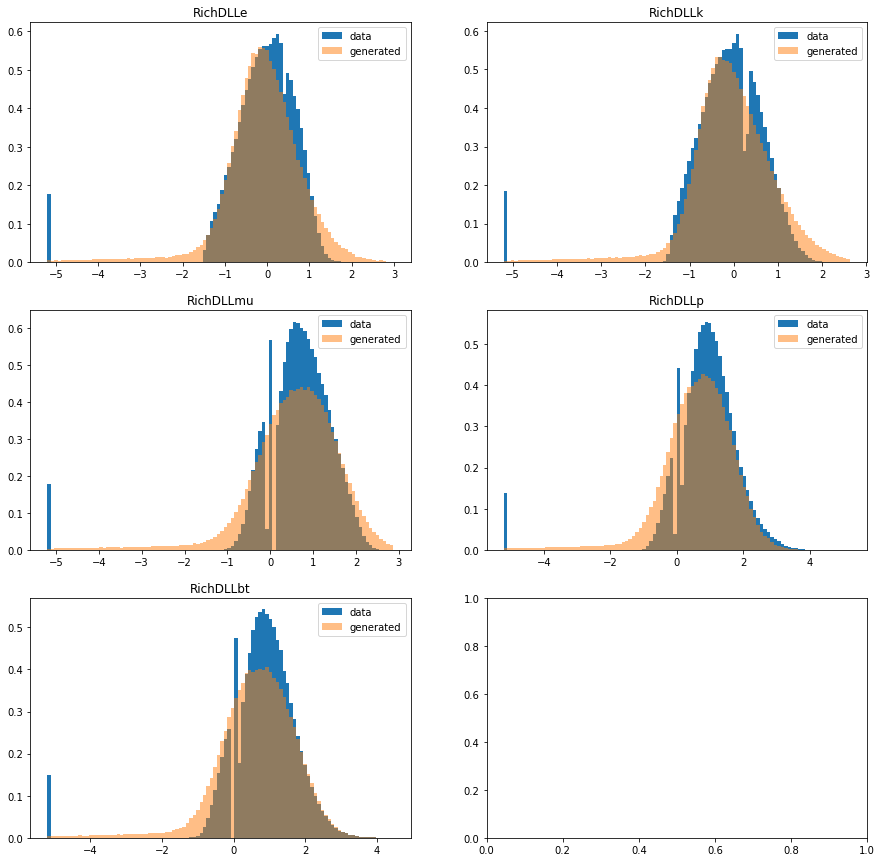

In [27]:
for ind, particle in enumerate(PARTICLES):
    print('particle: {}'.format(particle))
    with torch.no_grad():
        x, dlls, signal = [i.to(device).type(dtype) for i in next(validation_set[particle])]
        real_full = torch.cat([dlls, x], dim=1)

        labels = get_labels(x.shape[0], n_classes=len(PARTICLES))
        generated = netG(x, labels=labels)
        fig, axes = plt.subplots(3, 2, figsize=(15, 15))
        for INDEX, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
            _, bins, _ = ax.hist(dlls[:, INDEX].cpu(),
                                bins=100,
                                label="data",
                                density=True)
            ax.hist(generated[:, INDEX].cpu(),
                    bins=bins,
                    label="generated",
                    alpha=0.5,
                    density=True)
            ax.legend()
            ax.set_title(utils_rich.dll_columns[INDEX])
        plt.show()


In [29]:
from collections import defaultdict

eval_particles_loader = {particle: torch.utils.data.DataLoader(ParticleSet(data_val[data_val[particle] == 1].values),
                                                  batch_size=N_VAL,
                                                  shuffle=False,
                                                  pin_memory=True) for particle in PARTICLES}


particles_pred_dlls = defaultdict(list)
for particle in eval_particles_loader:
    for batch in tqdm(eval_particles_loader[particle], position=0, leave=True):
        x, dlls, signal = [i.to(device).type(dtype) for i in batch]
        labels = get_labels(x.shape[0], n_classes=len(PARTICLES))
        pred = netG(x, labels)
        particles_pred_dlls[particle].append(pred.detach().cpu().numpy())

100%|██████████| 4/4 [00:22<00:00,  5.65s/it]


In [0]:
data_val_c = data_val.copy()

In [0]:
data_val_c = data_val_c.drop(PARTICLES, axis=1)

In [0]:
cols = data_val_c.columns.tolist()
cols = cols[3:] + cols[:3]
data_val_c = data_val_c[cols]

In [0]:
pred_data_inversed = {}
val_data_inversed = {}
for i, particle in enumerate(particles_pred_dlls):
    pred_dlls = np.concatenate(particles_pred_dlls[particle], axis=0)
    pred_data = np.concatenate([pred_dlls, data_val_c[data_val[particle] == 1].values[:, utils_rich.y_count:]], axis=1)
    pred_data_inversed[particle] = scaler.inverse_transform(pred_data)
    val_data_inversed[particle] = scaler.inverse_transform(data_val_c[data_val[particle] == 1])

In [0]:
dlls = ['RichDLLe', 'RichDLLmu', 'RichDLLk' , 'RichDLLp', 'RichDLLbt']

In [0]:
val_data_inversed_ = {}
for particle in PARTICLES:
    val_data_inversed_[particle] = pd.DataFrame(val_data_inversed[particle], 
                                                columns=data_val_c.columns)
    for ind, col in enumerate(dlls):
        val_data_inversed_[particle]["predicted_"+col] = pred_data_inversed[particle][:, ind]
    val_data_inversed_[particle]['probe_sWeight'] = 1.0


In [0]:
class Wrapper:
    def __init__(self, data):
        self.test = data

wrap = lambda x, particle: {particle: Wrapper(x)}

In [43]:
val_data_inversed_['Electron'].head()

,RichDLLe,RichDLLk,RichDLLmu,RichDLLp,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,predicted_RichDLLe,predicted_RichDLLk,predicted_RichDLLmu,predicted_RichDLLp,predicted_RichDLLbt,probe_sWeight
0,12636.540273,682.116558,81.0,-0.794250,-4.711345,85.555105,36.492009,-35.990299,18987.806307,705.239053,32.0,-25.356771,-8.716320,1.0
1,57150.511840,365.126551,76.0,-2.101000,-0.398100,-88.315349,-81.245158,-1.853200,6098.420207,402.659496,67.0,-0.126508,0.824815,1.0
2,52613.946873,1549.608912,114.0,3.892357,2.533133,-3.548659,-1.084883,11.392900,14389.364461,205.907879,65.0,-0.577118,-0.098200,1.0
3,39396.674107,2235.660120,71.0,-3.363425,-0.806850,0.000000,-8.799731,-35.990299,4352.225751,976.574563,71.0,-3.119084,-0.377283,1.0
4,28298.573854,1474.061582,86.0,-0.241900,0.060500,0.249759,-10.445214,0.121600,102145.928429,3165.415667,55.0,-2.679730,-0.666838,1.0


In [45]:
from model_testing_mc import eval_model

particle_scores = []
for partcicle, vdata_inv in val_data_inversed_.items():
    scores, bins = eval_model(particle, wrap(vdata_inv, particle))
    particle_scores.append("Particle: {}, global test score: {} +- {}".format(particle,
                                                         scores.mean(axis=0)[0][1],
                                                         scores.std(axis=0)[0][1]))

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


ValueError: ignored

In [0]:
for res in particle_scores:
    print(res)

Particle: muon, global test score: 0.9442466540018497 +- 0.0007479634088663607
Particle: muon, global test score: 0.9655315664434126 +- 0.0006721489346370755
Particle: muon, global test score: 0.9399803749395493 +- 0.003072898575168907
Particle: muon, global test score: 0.9511500097224735 +- 0.0014470364906794641
